In [1]:
!wandb login

wandb: Currently logged in as: s-li2022 (sli2024). Use `wandb login --relogin` to force relogin


In [2]:
import os, gc, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import librosa

from tqdm.notebook import tqdm
from glob import glob

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader
import torch.nn.functional as F

import transformers
from transformers import ASTConfig, ASTFeatureExtractor, ASTModel

from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score

from time import time

import wandb

In [3]:
# print system info 
!nvidia-smi
!python --version

# print pytorch lightning version
print(f"Pytorch Version: {torch.__version__}")
print(f"Transformers Version: {transformers.__version__}")
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA Version:", torch.version.cuda)

Sat Jun  1 11:42:27 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.239.06   Driver Version: 470.239.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:0B:00.0 Off |                  N/A |
| 26%   34C    P8     5W / 260W |     15MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
def get_logger(log_file='log.txt'):
    import logging
    import sys
    
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter('%(message)s')
    # Logging to file
    file_handler = logging.FileHandler(log_file)
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)
    # Logging to console
    ch = logging.StreamHandler(sys.stdout)
    ch.setFormatter(formatter)
    logger.addHandler(ch)
    
    return logger

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def wandb_init(project_name, run_name, config):
    config_dict = {
        k: v for k, v in config.__dict__.items() if not k.startswith('_') and not callable(v) and k != 'copy'
    }
    run = wandb.init(project=project_name, name=run_name, config=config_dict)
    return run

In [5]:
DRIVE_FOLDER = "." #"/content/drive/MyDrive/Colab Notebooks"
KEEP_COLS = ['category_number', 'common_name', 'audio_length', 'type', 'remarks', 'quality', 'scientific_name', 'mp3_link', 'region']

class Config:
    dataset_dir = f"{DRIVE_FOLDER}/Audio_XenoCanto"
    labels_list = f"{DRIVE_FOLDER}/xeno_labels.csv"
    model_name = "BirdAST_SeqPool_GroupKFold"
    backbone_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
    n_classes = 728 # number of classes in the dataset
    audio_sr = 16000 #Hz
    segment_length = 10  #s
    fft_window = 0.025 #s
    hop_window_length = 0.01 #s
    n_mels = 128
    low_cut = 1000 #Hz
    high_cut = 8000 #Hz
    top_db = 100
    batch_size = 4 
    num_workers = 0
    n_splits = 5
    log_dir = f"{DRIVE_FOLDER}/training_logs"
    max_lr = 1e-5
    epochs = 10
    weight_decay = 0.01
    lr_final_div = 1000
    amp = True
    grad_accum_steps = 1
    max_grad_norm = 1e7
    print_epoch_freq = 1
    print_freq = 500
    random_seed = 2046
    
    @classmethod
    def copy(cls):
        new_class = type('CustomConfig', (cls,), {k: v for k, v in cls.__dict__.items() if not k.startswith('__') and not callable(v)})
        return new_class
    
config = Config.copy()

if not os.path.exists(config.log_dir):
    os.makedirs(config.log_dir)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed_everything(config.random_seed)

In [6]:
df_audio_meta = pd.read_csv(f"{config.dataset_dir}/metadata.csv", nrows=None)
df_audio_meta = df_audio_meta.dropna().reset_index(drop=True)

# Filter out files that do not exist
df_audio_meta['file_exists'] = df_audio_meta['file_name'].apply(lambda x: os.path.exists(f"{config.dataset_dir}/{x}"))
df_audio_meta = df_audio_meta[df_audio_meta['file_exists']].reset_index(drop=True)

# parse scientific names
df_audio_meta['scientific_name'] = df_audio_meta['scientific_name'].apply(lambda x: "_".join(x.split(" ")))

# drop species with less than 2 samples
class_counts = df_audio_meta['scientific_name'].value_counts()
print(f"Number of classes with less than 2 samples: {len(class_counts[class_counts < 2])}")

df_audio_meta = df_audio_meta[df_audio_meta['scientific_name'].isin(class_counts[class_counts > 1].index)].copy().reset_index(drop=True)

# encode scientific names to label ids
label_ids_list = df_audio_meta['scientific_name'].unique().tolist()
label_ids_list.sort()
label_to_id = {label: i for i, label in enumerate(label_ids_list)}
df_audio_meta['species_id'] = df_audio_meta['scientific_name'].map(label_to_id)

# save the label mapping
label_mapping = pd.DataFrame(label_to_id.items(), columns=['scientific_name', 'species_id'])
label_mapping.to_csv(f"{config.log_dir}/{config.model_name}_label_map.csv", index=False)

# drop samples with no labels
df_audio_meta.dropna(subset=['species_id'], inplace=True)
df_audio_meta.reset_index(drop=True, inplace=True)
df_audio_meta['species_id'] = df_audio_meta['species_id'].astype(int)

print(f"Number of classes in dataset: {df_audio_meta['species_id'].nunique()}")
print(f'Number of samples:', len(df_audio_meta))

# save the number of classes in the config
config.n_classes = df_audio_meta['species_id'].nunique()

# encode mp3 links to group ids for 5-folds
group_ids = df_audio_meta['mp3_link'].unique().tolist()
group_ids_map = {group_id: i for i, group_id in enumerate(group_ids)}
df_audio_meta['group_id'] = df_audio_meta['mp3_link'].map(group_ids_map)

df_audio_meta.to_csv(f"{config.log_dir}/{config.model_name}_metadata.csv", index=False)

df_audio_meta.head(5)

Number of classes with less than 2 samples: 72
Number of classes in dataset: 728
Number of samples: 11171


,file_name,category_number,common_name,audio_length,type,remarks,quality,mp3_link,scientific_name,region,file_exists,species_id,group_id
0,data/XC228210-Blue-crowned_Manakin_B_9369_0.wav,XC228210,Blue-crowned Manakin,0:20,call,ID certainty 80%. (Archiv. tape 393 side A tra...,B,//xeno-canto.org/sounds/uploaded/OOECIWCSWV/XC...,Lepidothrix_coronata,amazonas,True,329,0
1,data/XC228210-Blue-crowned_Manakin_B_9369_1.wav,XC228210,Blue-crowned Manakin,0:20,call,ID certainty 80%. (Archiv. tape 393 side A tra...,B,//xeno-canto.org/sounds/uploaded/OOECIWCSWV/XC...,Lepidothrix_coronata,amazonas,True,329,0
2,data/XC200163-PIPCOR03_0.wav,XC200163,Blue-crowned Manakin,0:42,"call, song","left bank of rio Negro - terra firme forest, w...",C,//xeno-canto.org/sounds/uploaded/DGVLLRYDXS/XC...,Lepidothrix_coronata,amazonas,True,329,1
3,data/XC200163-PIPCOR03_1.wav,XC200163,Blue-crowned Manakin,0:42,"call, song","left bank of rio Negro - terra firme forest, w...",C,//xeno-canto.org/sounds/uploaded/DGVLLRYDXS/XC...,Lepidothrix_coronata,amazonas,True,329,1
4,data/XC200163-PIPCOR03_2.wav,XC200163,Blue-crowned Manakin,0:42,"call, song","left bank of rio Negro - terra firme forest, w...",C,//xeno-canto.org/sounds/uploaded/DGVLLRYDXS/XC...,Lepidothrix_coronata,amazonas,True,329,1


In [7]:
# check if all species in greater_manaus are in amazonas
greater_manaus = df_audio_meta[df_audio_meta['region'] == 'greater_manaus']
amazonas = df_audio_meta[df_audio_meta['region'] == 'amazonas']

print('Number of species in greater_manaus:', len(greater_manaus['scientific_name'].unique()))
print('Number of species in amazonas:', len(amazonas['scientific_name'].unique()))

shared_species = [x for x in greater_manaus['scientific_name'].unique().tolist() if x in amazonas['scientific_name'].unique().tolist()]

print('Number of species in both regions:', len(shared_species))

Number of species in greater_manaus: 197
Number of species in amazonas: 724
Number of species in both regions: 193


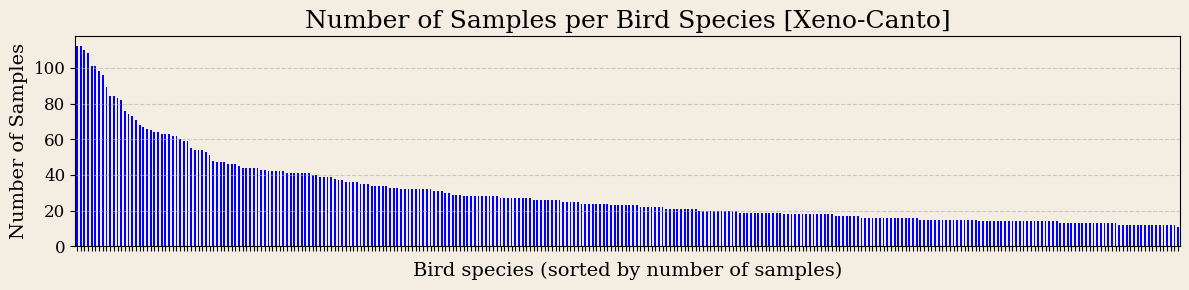

In [8]:
# calculate the number of samples per class and weights for focal loss
class_counts = df_audio_meta['species_id'].value_counts().sort_index()
class_weights = 1 / class_counts

# plot the distribution of the number of samples per class
fig, ax = plt.subplots(figsize=(12, 3))

class_counts_sorted = class_counts.sort_values(ascending=False)
class_counts.sort_values(ascending=False)[0:300].plot(ax=ax, kind='bar', color='blue')
ax.set_xticklabels([])
ax.tick_params(axis='y', labelcolor='black', labelsize=12, labelfontfamily='serif')
ax.set_xlabel('Bird species (sorted by number of samples)', fontsize=14, fontfamily='serif')
ax.set_ylabel('Number of Samples', fontsize=14, fontfamily='serif')
ax.set_title('Number of Samples per Bird Species [Xeno-Canto]', fontsize=18, fontfamily='serif')
ax.set_facecolor('#f3ede2')
fig.set_facecolor('#f3ede2')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

./Audio_XenoCanto/data/XC424956-Tachyphonus_cristatus_Musa_1133_2.wav


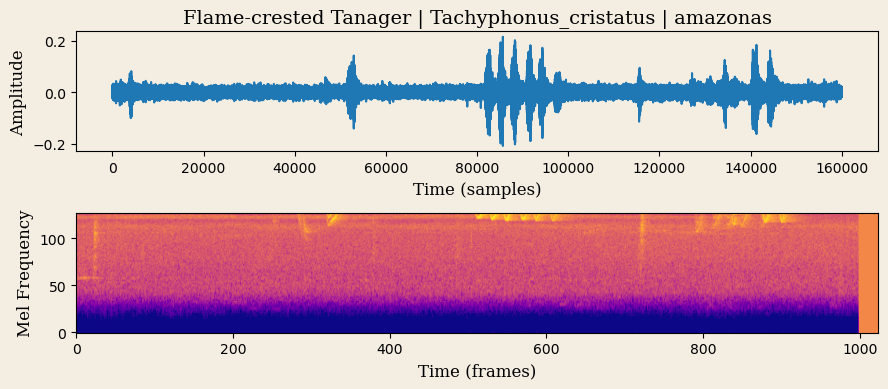

In [9]:
# visualize a sample audio file & spectrogram
sample = df_audio_meta.sample(1)

audio_file = f"{config.dataset_dir}/{sample['file_name'].values[0]}"
print(audio_file)

y, sr = librosa.load(audio_file, sr=config.audio_sr)

meta_str = f"{sample['common_name'].values[0]} | {sample['scientific_name'].values[0]} | {sample['region'].values[0]}"

fig, axes = plt.subplots(2, 1, figsize=(9, 4))

axes[0].plot(y)
axes[0].set_title(meta_str, fontsize=14, fontfamily='serif')
axes[0].set_xlabel('Time (samples)', fontsize=12, fontfamily='serif')
axes[0].set_ylabel('Amplitude', fontsize=12, fontfamily='serif')

mel_spec = ASTFeatureExtractor()(y, sampling_rate=sr, padding="max_length", return_tensors="np")["input_values"]

axes[1].imshow(mel_spec[0].T, aspect='auto', origin='lower', cmap='plasma')
axes[1].set_xlabel('Time (frames)', fontsize=12, fontfamily='serif')
axes[1].set_ylabel('Mel Frequency', fontsize=12, fontfamily='serif')

for ax in axes:
    ax.set_facecolor('#f3ede2')
    
fig.set_facecolor('#f3ede2')
fig.tight_layout()
plt.show()

In [10]:
class BirdSongDataset(Dataset):
    
    def __init__(self, df_audio_meta, config):
        self.df_audio_meta = df_audio_meta
        self.feature_extractor = ASTFeatureExtractor()
        self.config = config
    
    def __len__(self):
        return len(self.df_audio_meta)

    def __getitem__(self, idx):
        row = self.df_audio_meta.iloc[idx]
        audio_path = f"{self.config.dataset_dir}/{row['file_name']}"
        audio_arr, sr = self.get_audio(audio_path)
        spec = self.feature_extractor(audio_arr, sampling_rate=sr, padding="max_length", return_tensors="pt")
        return spec['input_values'].squeeze(0), row['species_id']

    def get_audio(self, audio_path):
        audio, sr = librosa.load(audio_path, sr=self.config.audio_sr)
        return audio, sr

def collate_fn(batch):
    inputs = [x[0] for x in batch]
    targets = [x[1] for x in batch]
    data_dict = {
        "input_ids": torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0),
        "labels": torch.tensor(targets)
    }
    return data_dict

In [11]:
# # test the dataset and dataloader
# bs_dataset = BirdSongDataset(df_audio_meta, config)
# bs_dataloader = DataLoader(bs_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

# for batch in bs_dataloader:
#     print(batch['input_ids'].shape)
#     print(batch['labels'])
#     break

In [12]:
# define loss_fn and eval_fn
class FocalLoss(nn.Module):
    
    def __init__(self, gamma=0, alpha=None, reduction='mean', device=DEVICE):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        
        if isinstance(alpha, (float, int, )): 
            self.alpha = torch.Tensor([alpha, 1-alpha])
        elif isinstance(alpha, (list, np.ndarray)): 
            self.alpha = torch.tensor(alpha, dtype=torch.float32, device=device)
        else:
            raise TypeError('Invalid alpha type')
        
        self.ce_loss = nn.CrossEntropyLoss(weight=self.alpha, reduction='none')

    def forward(self, logits, targets):
        ce_loss = self.ce_loss(logits, targets) # nn.CrossEntropyLoss already applies log_softmax
        pt = torch.exp(-ce_loss) # CE = -log(p_t) -> p_t = exp(-CE)
        
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        return_method = {
            'mean': torch.mean,
            'sum': torch.sum,
            'none': lambda x: x
        }
        
        return return_method[self.reduction](focal_loss)
        
# eval_fn
class ROC_AUC_Score(nn.Module):
    
    def __init__(self, config, average='macro', multi_class='ovo'):
        super(ROC_AUC_Score, self).__init__()
        self.num_classes = config.n_classes
        self.average = average
        self.multi_class = multi_class  # 'ovo' (one-vs-one) or 'ovr' (one-vs-rest)
        self.label_ids = np.arange(self.num_classes)

    def forward(self, logits, targets):
        # logits: (batch_size, n_classes)
        # targets: (batch_size,) with integer labels
        
        # Apply softmax to convert logits to probabilities
        probas = torch.exp(F.log_softmax(logits, dim=1))

        # Detach and move to CPU for sklearn compatibility
        probas = probas.detach().cpu().numpy()
        targets = targets.detach().cpu().numpy()
        
        df_scores = pd.DataFrame(probas, columns=self.label_ids)
        df_scores['target'] = targets
        
        # remove samples with classes which is predeicted as 0 in all samples
        unscored_cols = df_scores.columns[df_scores.sum(axis=0) == 0]
        rows_to_remove = df_scores['target'].isin(unscored_cols)
        df_scores = df_scores[~rows_to_remove]
        
        eval_score = roc_auc_score(
            y_true=df_scores['target'].values,
            y_score=df_scores[self.label_ids].values,
            average=self.average, 
            multi_class=self.multi_class,
            labels=self.label_ids
        )
        
        return eval_score


In [13]:
# # test loss_fn and eval_fn
# loss_fn = FocalLoss(gamma=2, alpha=class_weights.values, reduction='mean', device='cpu')
# eval_fn = ROC_AUC_Score(config, average='macro', multi_class='ovo')

# # target_labels = torch.tensor(df_audio_meta['species_id'].sample(10).values)
# target_labels = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# print('Target Labels:', target_labels, "\n")

# Test 1: perfect prediction
# logits_perfect = F.one_hot(target_labels, num_classes=config.n_classes).float() * 100
# loss_perfect = loss_fn(logits_perfect, target_labels)

# eval_score_perfect = eval_fn(logits_perfect, target_labels)
# print(f"Perfect Prediction: Loss: {loss_perfect.item()}, Eval Score: {eval_score_perfect}")
# print(" ")

# Test 2: half correct
# half_correct = target_labels.clone()
# half_correct[:5] = (half_correct[:5] + 1) % config.n_classes  
# logits_half = F.one_hot(half_correct, num_classes=config.n_classes).float() * 100
# logits_half[:5] *= -1  
# loss_half = loss_fn(logits_half, target_labels)

# eval_score_half = eval_fn(logits_half, target_labels)
# print(f"Half Correct Prediction: Loss: {loss_half.item()}, Eval Score: {eval_score_half}")
# print(" ")

# Test 3: random prediction
# logits_random = torch.rand((10, config.n_classes))
# loss_random = loss_fn(logits_random, target_labels)

# eval_score_random = eval_fn(logits_random, target_labels)
# print(f"Random Prediction: Loss: {loss_random.item()}, Eval Score: {eval_score_random}")

In [14]:
class SelfAttentionPooling(nn.Module):
    """
    Implementation of SelfAttentionPooling 
    Original Paper: Self-Attention Encoding and Pooling for Speaker Recognition
    https://arxiv.org/pdf/2008.01077v1.pdf
    """
    def __init__(self, input_dim):
        super(SelfAttentionPooling, self).__init__()
        self.W = nn.Linear(input_dim, 1)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, batch_rep):
        """
        input:
            batch_rep : size (N, T, H), N: batch size, T: sequence length, H: Hidden dimension
        attention_weight:
            att_w : size (N, T, 1)
        return:
            utter_rep: size (N, H)
        """
        att_w = self.softmax(self.W(batch_rep).squeeze(-1)).unsqueeze(-1)
        utter_rep = torch.sum(batch_rep * att_w, dim=1)

        return utter_rep


class BirdAST(nn.Module):
    
    def __init__(self, backbone_name, n_classes, n_mlp_layers=1, activation='silu'):
        super(BirdAST, self).__init__()
        
        # pre-trained backbone
        backbone_config = ASTConfig.from_pretrained(backbone_name)
        self.ast = ASTModel.from_pretrained(backbone_name, config=backbone_config)
        self.hidden_size = backbone_config.hidden_size
        
        # set activation functions
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'silu':
            self.activation = nn.SiLU()
        elif activation == 'gelu':
            self.activation = nn.GELU()
        else:
            raise ValueError("Unsupported activation function. Choose 'relu', 'silu' or 'gelu'")
        
        #define self-attention pooling layer
        self.sa_pool = SelfAttentionPooling(self.hidden_size)
        
        # define MLP layers with activation
        layers = []
        for _ in range(n_mlp_layers):
            layers.append(nn.Linear(self.hidden_size, self.hidden_size))
            layers.append(self.activation)
        layers.append(nn.Linear(self.hidden_size, n_classes))
        self.mlp = nn.Sequential(*layers)
        
        
    def forward(self, spectrogram):
        # spectrogram: (batch_size, n_mels, n_frames)
        # output: (batch_size, n_classes)
        
        ast_output = self.ast(spectrogram, output_hidden_states=False)
        hidden_state = ast_output.last_hidden_state
        pool_output = self.sa_pool(hidden_state)
        logits = self.mlp(pool_output)
        
        return {'logits': logits}

In [15]:
# # test the model / loss_fn / eval_fn using dataloader

# bs_dataset = BirdSongDataset(df_audio_meta, config)
# bs_dataloader = DataLoader(bs_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

# loss_fn = FocalLoss(gamma=2, alpha=class_weights.values, reduction='mean', device='cpu')
# eval_fn = ROC_AUC_Score(label_ids_list, average='macro')

# bird_ast_model = BirdAST(config.backbone_name, config.n_classes, n_mlp_layers=1, activation='silu')

# for batch in bs_dataloader:
    
#     input_ids = batch['input_ids']
#     labels = batch['labels']
    
#     output = bird_ast_model(input_ids)
#     logits = output['logits']
    
#     loss = loss_fn(logits, labels)
#     eval_score = eval_fn(logits, labels)
    
#     print(f"Shape of input_ids: {input_ids.shape}")
#     print(f"Shape of labels: {labels.shape}")
#     print(f"Shape of logits: {logits.shape}")
#     print(f"Loss: {loss.item()}, Eval Score: {eval_score}")
    
#     break

In [16]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.value = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.value = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
        
class Trainer:

    def __init__(self, model, loss_fn, evel_fn, logger, config, is_higher_better=True):
        '''
        model: nn.Module
        loss_fn: loss function
        evel_fn: evaluation function
        logger: logger
        config: Config
        is_higher_better: bool (default: True) whether higher evaluation score is better
        '''

        self.model = model
        self.logger = logger
        self.config = config
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.loss_fn = loss_fn
        self.loss_fn.to(self.device)
        
        self.eval_fn = evel_fn
        self.is_higher_better = is_higher_better
        
    def train(self, train_loader, valid_loader, print_epoch_freq=50, from_checkpoint=None, use_tqdm=True):

        self.optimizer = AdamW(self.model.parameters(), lr=1e-3, weight_decay=self.config.weight_decay)

        self.scheduler = OneCycleLR(
            self.optimizer,
            max_lr=self.config.max_lr,
            epochs=self.config.epochs,
            steps_per_epoch=len(train_loader),
            pct_start=0.1,
            anneal_strategy="cos",
            final_div_factor=self.config.lr_final_div,
        )

        if from_checkpoint is not None:
            self.model.load_state_dict(torch.load(from_checkpoint, map_location=self.device))

        self.model.to(self.device)
        best_weights, best_preds, best_loss = None, None, float("-inf") if self.is_higher_better else float("inf")
        loss_records = {"train": [], "valid": []}
        
        if use_tqdm:
            pbar = tqdm(range(self.config.epochs), total=self.config.epochs, unit="epoch", leave=True, desc="Training Progress")
        else:
            pbar = range(self.config.epochs)
            
        for epoch in pbar:
            start_epoch = time()

            train_loss, _ = self._train_or_valid_epoch(epoch, train_loader, is_train=True, use_tqdm=use_tqdm)
            valid_loss, valid_preds = self._train_or_valid_epoch(epoch, valid_loader, is_train=False, use_tqdm=use_tqdm)
            
            loss_records["train"].append(train_loss)
            loss_records["valid"].append(valid_loss)

            elapsed = time() - start_epoch
            
            if (epoch % print_epoch_freq == 0) or (epoch == (self.config.epochs - 1)):
                self.logger.info(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f} - Valid Loss: {valid_loss:.4f} - Elapsed Time: {elapsed:.2f}s")
            
            if self.is_higher_better:
                if valid_loss > best_loss:
                    best_loss = valid_loss
                    best_weights = self.model.state_dict()
                    best_preds = valid_preds
                    self.logger.info(f"- Epoch {epoch + 1}: Best model found with loss = {best_loss:.4f}.")
            else:
                if valid_loss < best_loss:
                    best_loss = valid_loss
                    best_weights = self.model.state_dict()
                    best_preds = valid_preds
                    self.logger.info(f"- Epoch {epoch + 1}: Best model found with loss = {best_loss:.4f}.")

        return best_weights, best_preds, loss_records

    def _train_or_valid_epoch(self, epoch_id, dataloader, is_train=True, use_tqdm=True):

        self.model.train() if is_train else self.model.eval()
        mode = "Train" if is_train else "Valid"

        len_loader = len(dataloader)
        scaler = GradScaler(enabled=self.config.amp)
        loss_meter = AverageMeter()
        labels_record, predicts_record = [], []

        start = time()
        
        if use_tqdm:
            pbar = tqdm(enumerate(dataloader), total=len_loader, desc=mode, unit="batch")
        else:
            pbar = enumerate(dataloader)
            
        for step, data_dict in pbar:
            
            input_ids = data_dict['input_ids'].to(self.device)
            labels = data_dict['labels'].to(self.device)
            
            if is_train:
                with autocast(enabled=self.config.amp):
                    model_output = self.model(input_ids)
                    logits = model_output['logits']
                    train_loss = self.loss_fn(logits, labels)
                    
                if self.config.grad_accum_steps > 1:
                    train_loss = train_loss / self.config.grad_accum_steps
                    
                scaler.scale(train_loss).backward()
                grad_norm = torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.max_grad_norm)
                if (step + 1) % self.config.grad_accum_steps == 0:
                    scaler.step(self.optimizer)
                    scaler.update()
                    self.optimizer.zero_grad()
                    self.scheduler.step()
                    
                loss_meter.update(train_loss.item())
                
            else:
                with torch.no_grad():
                    model_output = self.model(input_ids)
                    logits = model_output['logits']
                    valid_loss = self.loss_fn(logits, labels)

                if self.config.grad_accum_steps > 1:
                    valid_loss = valid_loss / self.config.grad_accum_steps
                    
                loss_meter.update(valid_loss.item())
                
                predicts_record.append(logits)
                labels_record.append(labels)
            
            end = time()
            
            if self.config.print_freq:
                if (step % self.config.print_freq == 0) or (step == (len_loader - 1)):
                    lr = self.scheduler.get_last_lr()[0]
                    info = f"Epoch {epoch_id + 1} [{step}/{len_loader}] | {mode} "
                    
                    if is_train:
                        info += f"Loss: {loss_meter.avg:.4f} Grad: {grad_norm:.4f} LR: {lr:.4e}"
                    else:
                        info += f"Loss: {loss_meter.avg:.4f}"

                    info += f" | Elapse: {end - start:.2f}s"
                    self.logger.info(info)

        if is_train:
            wandb.log({
                "Train Loss": loss_meter.avg, 
                "Learning Rate": self.scheduler.get_last_lr()[0],
                "Gradient Norm": grad_norm,
                "Epoch": epoch_id + 1
            })
            return loss_meter.avg, None
        else:
            eval_loss = self.eval_fn(
                torch.cat(predicts_record).cpu(),
                torch.cat(labels_record).cpu()
                )
            wandb.log({
                "Valid Loss": loss_meter.avg,
                "Eval Score": eval_loss,
                "Epoch": epoch_id + 1
            })
            predicts_record = np.concatenate([p.cpu().detach().numpy() for p in predicts_record], axis=0)
            return eval_loss, predicts_record


In [17]:
def plot_loss_record(loss_history, final_loss, start_at=0, save_to=None):
    
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
    ax2 = ax1.twinx()
    for i, loss in enumerate(loss_history):
        ax1.plot(np.arange(start_at, len(loss['train'])), loss['train'][start_at:], "-",   label=f'Train_{i}')
        ax2.plot(np.arange(start_at, len(loss['valid'])), loss['valid'][start_at:], ".--", label=f'Valid_{i}')
        
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Train Loss")
    ax2.set_ylabel("Valid Loss (Dashed)")
    ax1.set_title(f"Final Eval-Loss: {final_loss:.4f}")
    ax1.legend(loc='lower left', bbox_to_anchor=[1.15, 0])
    ax2.legend(loc='upper left', bbox_to_anchor=[1.15, 1])
    
    if save_to:
        plt.savefig(save_to)
    
    fig.tight_layout()
    plt.show()

In [18]:
gkf = GroupKFold(n_splits=config.n_splits)
df_audio_meta['fold'] = 0

for fold, (train_index, test_index) in enumerate(gkf.split(df_audio_meta, groups=df_audio_meta['group_id'])):
    df_audio_meta.loc[test_index, 'fold'] = fold
    
display(df_audio_meta['fold'].value_counts())

# check if any sample in valid set has the same mp3_link as the train set
for fold in range(config.n_splits):
    train_group_ids = df_audio_meta[df_audio_meta['fold'] != fold]['mp3_link'].unique()
    valid_group_ids = df_audio_meta[df_audio_meta['fold'] == fold]['mp3_link'].unique()
    common_groups = set(train_group_ids).intersection(set(valid_group_ids))
    print(f"Fold {fold}: Number of common groups between train and valid: {len(common_groups)}")

fold
0    2235
2    2234
3    2234
1    2234
4    2234
Name: count, dtype: int64

Fold 0: Number of common groups between train and valid: 0
Fold 1: Number of common groups between train and valid: 0
Fold 2: Number of common groups between train and valid: 0
Fold 3: Number of common groups between train and valid: 0
Fold 4: Number of common groups between train and valid: 0


In [19]:
loss_fn = FocalLoss(gamma=2, alpha=class_weights.values, reduction='mean', device='cpu')
eval_fn = ROC_AUC_Score(config, average='macro', multi_class='ovo')

oof, loss_history = pd.DataFrame(), []

logger = get_logger(log_file=f"{config.log_dir}/{config.model_name}_training.log")

# log TRAIN_CONFIG
logger.info(f"{'#'*35} TRAIN_CONFIG {'#'*35}")
for k, v in config.__dict__.items():
    if '__' not in k:
        logger.info(f"{k}: {v}")

logger.info(f"{'#'*80}")

################################### TRAIN_CONFIG ###################################
dataset_dir: ./Audio_XenoCanto
labels_list: ./xeno_labels.csv
model_name: BirdAST_SeqPool_GroupKFold
backbone_name: MIT/ast-finetuned-audioset-10-10-0.4593
n_classes: 728
audio_sr: 16000
segment_length: 10
fft_window: 0.025
hop_window_length: 0.01
n_mels: 128
low_cut: 1000
high_cut: 8000
top_db: 100
batch_size: 4
num_workers: 0
n_splits: 5
log_dir: ./training_logs
max_lr: 1e-05
epochs: 10
weight_decay: 0.01
lr_final_div: 1000
amp: True
grad_accum_steps: 1
max_grad_norm: 10000000.0
print_epoch_freq: 1
print_freq: 500
random_seed: 2046
copy: <classmethod(<function Config.copy at 0x7f3645219260>)>
################################################################################


In [20]:
# --------------------------------------------------------------
# Training Loop Starts Here
# --------------------------------------------------------------
loader_kwargs = {
    "batch_size": config.batch_size,
    "num_workers": config.num_workers,
    "pin_memory": True,
    "shuffle": False,
    'collate_fn': collate_fn
}

prediction_columns = [f"pred_{i}" for i in range(config.n_classes)]
    
for fold_id in range(0, config.n_splits):
    tik = time()
    
    wandb_init(project_name=config.model_name, run_name=f"fold_{fold_id}", config=config)
    
    train_df = df_audio_meta[df_audio_meta['fold'] != fold_id].copy().reset_index(drop=True)
    valid_df = df_audio_meta[df_audio_meta['fold'] == fold_id].copy().reset_index(drop=True)
    
    train_folds = BirdSongDataset(train_df, config)
    valid_folds = BirdSongDataset(valid_df, config)
    
    train_loader = DataLoader(train_folds, **loader_kwargs)
    valid_loader = DataLoader(valid_folds, **loader_kwargs)
        
    model = BirdAST(config.backbone_name, config.n_classes, n_mlp_layers=1, activation='silu')
    
    trainer = Trainer(model, loss_fn, eval_fn, logger, config, is_higher_better=True)
    
    best_weights, best_preds, loss_records = trainer.train( 
        train_loader, 
        valid_loader, 
        print_epoch_freq=config.print_epoch_freq,
        from_checkpoint=None,
        use_tqdm=True
        )
    
    loss_history.append(loss_records)
    
    df_valid = pd.DataFrame({'species_id': valid_df['species_id'], 'fold': fold})
    df_valid[prediction_columns] = best_preds
    
    oof = pd.concat([oof, df_valid], axis=0).reset_index(drop=True)
    
    save_model_name = f"{config.model_name}_fold_{fold_id}"
    torch.save(best_weights, f"{config.log_dir}/{save_model_name}.pth")

    del train_folds, valid_folds, train_loader, valid_loader
    torch.cuda.empty_cache()
    gc.collect()
    
    valid_loss_fold = eval_fn(
        torch.tensor(oof[prediction_columns].values),
        torch.tensor(oof['species_id'].values)
    )
    logger.info(f"Fold {fold_id} | Time: {(time() - tik)/60:.2f}min | Overall Evaluation Loss: {valid_loss_fold:.4f}")
    
    # Save the oof predictions
    oof.to_csv(f"{config.log_dir}/{config.model_name}_oof.csv", index=False)
    
    wandb.finish()
        
# Summarize the final results
valid_loss = eval_fn(
    torch.tensor(oof[prediction_columns].values),
    torch.tensor(oof['species_id'].values)
)

plot_loss_record(loss_history, valid_loss, start_at=0, save_to=os.path.join(config.log_dir, f"{config.model_name}_loss.jpg"))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: s-li2022 (sli2024). Use `wandb login --relogin` to force relogin


Training Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Train:   0%|          | 0/2234 [00:00<?, ?batch/s]

Epoch 1 [0/2234] | Train Loss: 0.0083 Grad: 3080.9939 LR: 4.0000e-07 | Elapse: 1.05s
Epoch 1 [500/2234] | Train Loss: 0.2131 Grad: 5887.1758 LR: 1.5438e-06 | Elapse: 108.37s
Epoch 1 [1000/2234] | Train Loss: 0.2016 Grad: 2543.6912 LR: 4.4234e-06 | Elapse: 218.29s
Epoch 1 [1500/2234] | Train Loss: 0.1774 Grad: 1406.0856 LR: 7.6718e-06 | Elapse: 329.31s
Epoch 1 [2000/2234] | Train Loss: 0.1725 Grad: 33254.6016 LR: 9.7466e-06 | Elapse: 440.79s
Epoch 1 [2233/2234] | Train Loss: 0.1627 Grad: 16401.9609 LR: 1.0000e-05 | Elapse: 492.78s


Valid:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 1 [0/559] | Valid Loss: 0.0055 | Elapse: 0.22s
Epoch 1 [500/559] | Valid Loss: 0.1840 | Elapse: 75.66s
Epoch 1 [558/559] | Valid Loss: 0.1744 | Elapse: 84.46s
Epoch 1 - Train Loss: 0.1627 - Valid Loss: 0.5256 - Elapsed Time: 605.12s
- Epoch 1: Best model found with loss = 0.5256.


Train:   0%|          | 0/2234 [00:00<?, ?batch/s]

Epoch 2 [0/2234] | Train Loss: 0.0091 Grad: 4227.4209 LR: 1.0000e-05 | Elapse: 0.25s
Epoch 2 [500/2234] | Train Loss: 0.2105 Grad: 4662.0063 LR: 9.9846e-06 | Elapse: 110.70s
Epoch 2 [1000/2234] | Train Loss: 0.1964 Grad: 2484.5747 LR: 9.9388e-06 | Elapse: 222.31s
Epoch 2 [1500/2234] | Train Loss: 0.1676 Grad: 1345.9922 LR: 9.8629e-06 | Elapse: 333.97s
Epoch 2 [2000/2234] | Train Loss: 0.1558 Grad: 50965.1875 LR: 9.7574e-06 | Elapse: 445.66s
Epoch 2 [2233/2234] | Train Loss: 0.1466 Grad: 23711.8379 LR: 9.6982e-06 | Elapse: 497.71s


Valid:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 2 [0/559] | Valid Loss: 0.0062 | Elapse: 0.15s
Epoch 2 [500/559] | Valid Loss: 0.2152 | Elapse: 75.11s
Epoch 2 [558/559] | Valid Loss: 0.2042 | Elapse: 83.83s
Epoch 2 - Train Loss: 0.1466 - Valid Loss: 0.5210 - Elapsed Time: 609.10s


Train:   0%|          | 0/2234 [00:00<?, ?batch/s]

Epoch 3 [0/2234] | Train Loss: 0.0103 Grad: 6816.2998 LR: 9.6979e-06 | Elapse: 0.25s
Epoch 3 [500/2234] | Train Loss: 0.1771 Grad: 5897.7886 LR: 9.5500e-06 | Elapse: 110.61s
Epoch 3 [1000/2234] | Train Loss: 0.1637 Grad: 3539.9851 LR: 9.3744e-06 | Elapse: 221.98s
Epoch 3 [1500/2234] | Train Loss: 0.1343 Grad: 1684.6792 LR: 9.1720e-06 | Elapse: 333.19s
Epoch 3 [2000/2234] | Train Loss: 0.1216 Grad: 55989.0430 LR: 8.9442e-06 | Elapse: 444.56s
Epoch 3 [2233/2234] | Train Loss: 0.1151 Grad: 28249.8770 LR: 8.8298e-06 | Elapse: 496.55s


Valid:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 3 [0/559] | Valid Loss: 0.0060 | Elapse: 0.16s
Epoch 3 [500/559] | Valid Loss: 0.2430 | Elapse: 75.30s
Epoch 3 [558/559] | Valid Loss: 0.2307 | Elapse: 84.03s
Epoch 3 - Train Loss: 0.1151 - Valid Loss: 0.5247 - Elapsed Time: 608.49s


Train:   0%|          | 0/2234 [00:00<?, ?batch/s]

Epoch 4 [0/2234] | Train Loss: 0.0095 Grad: 8173.5962 LR: 8.8293e-06 | Elapse: 0.25s
Epoch 4 [500/2234] | Train Loss: 0.1485 Grad: 10311.9189 LR: 8.5667e-06 | Elapse: 110.58s
Epoch 4 [1000/2234] | Train Loss: 0.1338 Grad: 3481.2400 LR: 8.2823e-06 | Elapse: 222.13s
Epoch 4 [1500/2234] | Train Loss: 0.1063 Grad: 1568.0475 LR: 7.9779e-06 | Elapse: 333.77s
Epoch 4 [2000/2234] | Train Loss: 0.0949 Grad: 28348.4316 LR: 7.6554e-06 | Elapse: 445.31s
Epoch 4 [2233/2234] | Train Loss: 0.0904 Grad: 15313.8545 LR: 7.4994e-06 | Elapse: 497.25s


Valid:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 4 [0/559] | Valid Loss: 0.0059 | Elapse: 0.16s
Epoch 4 [500/559] | Valid Loss: 0.2749 | Elapse: 75.05s
Epoch 4 [558/559] | Valid Loss: 0.2614 | Elapse: 83.75s
Epoch 4 - Train Loss: 0.0904 - Valid Loss: 0.5125 - Elapsed Time: 608.62s


Train:   0%|          | 0/2234 [00:00<?, ?batch/s]

Epoch 5 [0/2234] | Train Loss: 0.0092 Grad: 8866.0664 LR: 7.4987e-06 | Elapse: 0.24s
Epoch 5 [500/2234] | Train Loss: 0.1255 Grad: 8604.9102 LR: 7.1531e-06 | Elapse: 110.37s
Epoch 5 [1000/2234] | Train Loss: 0.1072 Grad: 3542.6089 LR: 6.7944e-06 | Elapse: 221.61s
Epoch 5 [1500/2234] | Train Loss: 0.0839 Grad: 1654.8899 LR: 6.4247e-06 | Elapse: 332.84s
Epoch 5 [2000/2234] | Train Loss: 0.0753 Grad: 24916.0488 LR: 6.0463e-06 | Elapse: 444.28s
Epoch 5 [2233/2234] | Train Loss: 0.0720 Grad: 16369.3408 LR: 5.8676e-06 | Elapse: 496.31s


Valid:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 5 [0/559] | Valid Loss: 0.0057 | Elapse: 0.16s
Epoch 5 [500/559] | Valid Loss: 0.2950 | Elapse: 75.08s
Epoch 5 [558/559] | Valid Loss: 0.2806 | Elapse: 83.79s
Epoch 5 - Train Loss: 0.0720 - Valid Loss: 0.5099 - Elapsed Time: 607.79s


Train:   0%|          | 0/2234 [00:00<?, ?batch/s]

Epoch 6 [0/2234] | Train Loss: 0.0089 Grad: 9166.0918 LR: 5.8669e-06 | Elapse: 0.25s
Epoch 6 [500/2234] | Train Loss: 0.1092 Grad: 9618.9873 LR: 5.4799e-06 | Elapse: 110.25s
Epoch 6 [1000/2234] | Train Loss: 0.0927 Grad: 3401.7583 LR: 5.0900e-06 | Elapse: 221.50s
Epoch 6 [1500/2234] | Train Loss: 0.0701 Grad: 1604.1074 LR: 4.6996e-06 | Elapse: 332.71s
Epoch 6 [2000/2234] | Train Loss: 0.0626 Grad: 28865.2969 LR: 4.3110e-06 | Elapse: 444.26s
Epoch 6 [2233/2234] | Train Loss: 0.0602 Grad: 15604.0322 LR: 4.1312e-06 | Elapse: 496.27s


Valid:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 6 [0/559] | Valid Loss: 0.0063 | Elapse: 0.16s
Epoch 6 [500/559] | Valid Loss: 0.3165 | Elapse: 74.94s
Epoch 6 [558/559] | Valid Loss: 0.3013 | Elapse: 83.66s
Epoch 6 - Train Loss: 0.0602 - Valid Loss: 0.5292 - Elapsed Time: 607.32s
- Epoch 6: Best model found with loss = 0.5292.


Train:   0%|          | 0/2234 [00:00<?, ?batch/s]

Epoch 7 [0/2234] | Train Loss: 0.0096 Grad: 10347.9707 LR: 4.1305e-06 | Elapse: 0.24s
Epoch 7 [500/2234] | Train Loss: 0.0994 Grad: 4625.2993 LR: 3.7488e-06 | Elapse: 110.36s
Epoch 7 [1000/2234] | Train Loss: 0.0799 Grad: 1707.7841 LR: 3.3749e-06 | Elapse: 221.81s
Epoch 7 [1500/2234] | Train Loss: 0.0596 Grad: 935.5480 LR: 3.0108e-06 | Elapse: 333.09s
Epoch 7 [2000/2234] | Train Loss: 0.0544 Grad: 36463.6680 LR: 2.6589e-06 | Elapse: 444.18s
Epoch 7 [2233/2234] | Train Loss: 0.0527 Grad: 30229.2129 LR: 2.4996e-06 | Elapse: 496.13s


Valid:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 7 [0/559] | Valid Loss: 0.0057 | Elapse: 0.16s
Epoch 7 [500/559] | Valid Loss: 0.3223 | Elapse: 74.93s
Epoch 7 [558/559] | Valid Loss: 0.3064 | Elapse: 83.59s
Epoch 7 - Train Loss: 0.0527 - Valid Loss: 0.5366 - Elapsed Time: 606.89s
- Epoch 7: Best model found with loss = 0.5366.


Train:   0%|          | 0/2234 [00:00<?, ?batch/s]

Epoch 8 [0/2234] | Train Loss: 0.0093 Grad: 10026.4893 LR: 2.4989e-06 | Elapse: 0.25s
Epoch 8 [500/2234] | Train Loss: 0.0887 Grad: 4765.6313 LR: 2.1687e-06 | Elapse: 110.19s
Epoch 8 [1000/2234] | Train Loss: 0.0740 Grad: 1782.7578 LR: 1.8557e-06 | Elapse: 221.55s
Epoch 8 [1500/2234] | Train Loss: 0.0559 Grad: 892.2927 LR: 1.5619e-06 | Elapse: 333.08s
Epoch 8 [2000/2234] | Train Loss: 0.0508 Grad: 37116.0586 LR: 1.2891e-06 | Elapse: 444.69s
Epoch 8 [2233/2234] | Train Loss: 0.0498 Grad: 31871.5957 LR: 1.1696e-06 | Elapse: 496.46s


Valid:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 8 [0/559] | Valid Loss: 0.0055 | Elapse: 0.16s
Epoch 8 [500/559] | Valid Loss: 0.3140 | Elapse: 74.40s
Epoch 8 [558/559] | Valid Loss: 0.2982 | Elapse: 83.03s
Epoch 8 - Train Loss: 0.0498 - Valid Loss: 0.5415 - Elapsed Time: 606.55s
- Epoch 8: Best model found with loss = 0.5415.


Train:   0%|          | 0/2234 [00:00<?, ?batch/s]

Epoch 9 [0/2234] | Train Loss: 0.0099 Grad: 11485.1738 LR: 1.1691e-06 | Elapse: 0.25s
Epoch 9 [500/2234] | Train Loss: 0.0877 Grad: 9724.9004 LR: 9.3008e-07 | Elapse: 110.16s
Epoch 9 [1000/2234] | Train Loss: 0.0805 Grad: 5832.6860 LR: 7.1586e-07 | Elapse: 220.80s
Epoch 9 [1500/2234] | Train Loss: 0.0634 Grad: 2033.9180 LR: 5.2778e-07 | Elapse: 331.89s
Epoch 9 [2000/2234] | Train Loss: 0.0581 Grad: 91771.5781 LR: 3.6699e-07 | Elapse: 442.77s
Epoch 9 [2233/2234] | Train Loss: 0.0569 Grad: 32582.9395 LR: 3.0166e-07 | Elapse: 494.32s


Valid:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 9 [0/559] | Valid Loss: 0.0053 | Elapse: 0.16s
Epoch 9 [500/559] | Valid Loss: 0.3227 | Elapse: 74.72s
Epoch 9 [558/559] | Valid Loss: 0.3062 | Elapse: 83.35s
Epoch 9 - Train Loss: 0.0569 - Valid Loss: 0.5542 - Elapsed Time: 604.49s
- Epoch 9: Best model found with loss = 0.5542.


Train:   0%|          | 0/2234 [00:00<?, ?batch/s]

Epoch 10 [0/2234] | Train Loss: 0.0085 Grad: 10368.0166 LR: 3.0139e-07 | Elapse: 0.25s
Epoch 10 [500/2234] | Train Loss: 0.1059 Grad: 7152.4902 LR: 1.8238e-07 | Elapse: 109.90s
Epoch 10 [1000/2234] | Train Loss: 0.1183 Grad: 4816.2651 LR: 9.2753e-08 | Elapse: 220.50s
Epoch 10 [1500/2234] | Train Loss: 0.1015 Grad: 2525.6731 LR: 3.3068e-08 | Elapse: 331.20s
Epoch 10 [2000/2234] | Train Loss: 0.1174 Grad: 47074.2617 LR: 3.6847e-09 | Elapse: 441.78s
Epoch 10 [2233/2234] | Train Loss: 0.1119 Grad: 55037.0117 LR: 4.0006e-10 | Elapse: 493.28s


Valid:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 10 [0/559] | Valid Loss: 0.0103 | Elapse: 0.15s
Epoch 10 [500/559] | Valid Loss: 0.2815 | Elapse: 74.50s
Epoch 10 [558/559] | Valid Loss: 0.2678 | Elapse: 83.11s
Epoch 10 - Train Loss: 0.1119 - Valid Loss: 0.5808 - Elapsed Time: 603.42s
- Epoch 10: Best model found with loss = 0.5808.


/tmp/ipykernel_1275771/81986051.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_valid[prediction_columns] = best_preds
/tmp/ipykernel_1275771/81986051.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_valid[prediction_columns] = best_preds
/tmp/ipykernel_1275771/81986051.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

Fold 0 | Time: 101.77min | Overall Evaluation Loss: 0.5808


Epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
Eval Score,▃▂▂▁▁▃▄▄▅█
Gradient Norm,▁▂▃▁▁▁▄▄▄█
Learning Rate,██▇▆▅▄▃▂▁▁
Train Loss,█▇▅▄▂▂▁▁▁▅
Valid Loss,▁▃▄▆▇████▆
Epoch,10
Eval Score,0.58083
Gradient Norm,55037.01172
Learning Rate,0.0
Train Loss,0.11193


Training Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Train:   0%|          | 0/2235 [00:00<?, ?batch/s]

Epoch 1 [0/2235] | Train Loss: 0.0081 Grad: 3268.6914 LR: 4.0000e-07 | Elapse: 0.25s
Epoch 1 [500/2235] | Train Loss: 0.1977 Grad: 499.0406 LR: 1.5428e-06 | Elapse: 109.28s
Epoch 1 [1000/2235] | Train Loss: 0.2031 Grad: 3093.0850 LR: 4.4205e-06 | Elapse: 220.47s
Epoch 1 [1500/2235] | Train Loss: 0.1794 Grad: 1354.9590 LR: 7.6679e-06 | Elapse: 331.78s
Epoch 1 [2000/2235] | Train Loss: 0.1706 Grad: 1543.3955 LR: 9.7446e-06 | Elapse: 443.19s
Epoch 1 [2234/2235] | Train Loss: 0.1599 Grad: 36887.7109 LR: 1.0000e-05 | Elapse: 495.10s


Valid:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 1 [0/559] | Valid Loss: 0.0017 | Elapse: 0.15s
Epoch 1 [500/559] | Valid Loss: 0.1951 | Elapse: 74.76s
Epoch 1 [558/559] | Valid Loss: 0.1870 | Elapse: 83.39s
Epoch 1 - Train Loss: 0.1599 - Valid Loss: 0.5176 - Elapsed Time: 605.94s
- Epoch 1: Best model found with loss = 0.5176.


Train:   0%|          | 0/2235 [00:00<?, ?batch/s]

Epoch 2 [0/2235] | Train Loss: 0.0089 Grad: 3293.0122 LR: 1.0000e-05 | Elapse: 0.25s
Epoch 2 [500/2235] | Train Loss: 0.1931 Grad: 592.7904 LR: 9.9846e-06 | Elapse: 110.14s
Epoch 2 [1000/2235] | Train Loss: 0.1950 Grad: 3412.0400 LR: 9.9389e-06 | Elapse: 221.42s
Epoch 2 [1500/2235] | Train Loss: 0.1684 Grad: 976.0983 LR: 9.8631e-06 | Elapse: 332.61s
Epoch 2 [2000/2235] | Train Loss: 0.1557 Grad: 841.5506 LR: 9.7576e-06 | Elapse: 443.55s
Epoch 2 [2234/2235] | Train Loss: 0.1459 Grad: 31879.6895 LR: 9.6982e-06 | Elapse: 495.28s


Valid:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 2 [0/559] | Valid Loss: 0.0023 | Elapse: 0.16s
Epoch 2 [500/559] | Valid Loss: 0.2245 | Elapse: 74.91s
Epoch 2 [558/559] | Valid Loss: 0.2156 | Elapse: 83.53s
Epoch 2 - Train Loss: 0.1459 - Valid Loss: 0.5400 - Elapsed Time: 606.25s
- Epoch 2: Best model found with loss = 0.5400.


Train:   0%|          | 0/2235 [00:00<?, ?batch/s]

Epoch 3 [0/2235] | Train Loss: 0.0112 Grad: 6795.4248 LR: 9.6979e-06 | Elapse: 0.25s
Epoch 3 [500/2235] | Train Loss: 0.1590 Grad: 463.1453 LR: 9.5501e-06 | Elapse: 110.11s
Epoch 3 [1000/2235] | Train Loss: 0.1559 Grad: 4124.1533 LR: 9.3745e-06 | Elapse: 221.17s
Epoch 3 [1500/2235] | Train Loss: 0.1323 Grad: 1389.1621 LR: 9.1723e-06 | Elapse: 331.77s
Epoch 3 [2000/2235] | Train Loss: 0.1198 Grad: 1269.5016 LR: 8.9447e-06 | Elapse: 442.57s
Epoch 3 [2234/2235] | Train Loss: 0.1128 Grad: 42357.4297 LR: 8.8298e-06 | Elapse: 494.33s


Valid:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 3 [0/559] | Valid Loss: 0.0029 | Elapse: 0.16s
Epoch 3 [500/559] | Valid Loss: 0.2661 | Elapse: 74.86s
Epoch 3 [558/559] | Valid Loss: 0.2560 | Elapse: 83.50s
Epoch 3 - Train Loss: 0.1128 - Valid Loss: 0.5389 - Elapsed Time: 604.64s


Train:   0%|          | 0/2235 [00:00<?, ?batch/s]

Epoch 4 [0/2235] | Train Loss: 0.0138 Grad: 10572.1230 LR: 8.8293e-06 | Elapse: 0.24s
Epoch 4 [500/2235] | Train Loss: 0.1211 Grad: 706.6685 LR: 8.5668e-06 | Elapse: 110.09s
Epoch 4 [1000/2235] | Train Loss: 0.1158 Grad: 3690.2581 LR: 8.2826e-06 | Elapse: 220.88s
Epoch 4 [1500/2235] | Train Loss: 0.0971 Grad: 1535.0525 LR: 7.9784e-06 | Elapse: 331.70s
Epoch 4 [2000/2235] | Train Loss: 0.0872 Grad: 1396.4438 LR: 7.6560e-06 | Elapse: 442.46s
Epoch 4 [2234/2235] | Train Loss: 0.0830 Grad: 42917.0508 LR: 7.4994e-06 | Elapse: 494.21s


Valid:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 4 [0/559] | Valid Loss: 0.0027 | Elapse: 0.16s
Epoch 4 [500/559] | Valid Loss: 0.2832 | Elapse: 74.93s
Epoch 4 [558/559] | Valid Loss: 0.2724 | Elapse: 83.55s
Epoch 4 - Train Loss: 0.0830 - Valid Loss: 0.5559 - Elapsed Time: 604.89s
- Epoch 4: Best model found with loss = 0.5559.


Train:   0%|          | 0/2235 [00:00<?, ?batch/s]

Epoch 5 [0/2235] | Train Loss: 0.0136 Grad: 11805.4395 LR: 7.4987e-06 | Elapse: 0.24s
Epoch 5 [500/2235] | Train Loss: 0.0856 Grad: 802.7752 LR: 7.1533e-06 | Elapse: 110.14s
Epoch 5 [1000/2235] | Train Loss: 0.0813 Grad: 3047.3679 LR: 6.7947e-06 | Elapse: 220.95s
Epoch 5 [1500/2235] | Train Loss: 0.0698 Grad: 1609.1740 LR: 6.4252e-06 | Elapse: 331.92s
Epoch 5 [2000/2235] | Train Loss: 0.0626 Grad: 1561.7319 LR: 6.0470e-06 | Elapse: 442.77s
Epoch 5 [2234/2235] | Train Loss: 0.0606 Grad: 43952.4492 LR: 5.8676e-06 | Elapse: 494.70s


Valid:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 5 [0/559] | Valid Loss: 0.0028 | Elapse: 0.17s
Epoch 5 [500/559] | Valid Loss: 0.3029 | Elapse: 75.28s
Epoch 5 [558/559] | Valid Loss: 0.2918 | Elapse: 83.93s
Epoch 5 - Train Loss: 0.0606 - Valid Loss: 0.5616 - Elapsed Time: 605.72s
- Epoch 5: Best model found with loss = 0.5616.


Train:   0%|          | 0/2235 [00:00<?, ?batch/s]

Epoch 6 [0/2235] | Train Loss: 0.0133 Grad: 13505.1270 LR: 5.8669e-06 | Elapse: 0.24s
Epoch 6 [500/2235] | Train Loss: 0.0614 Grad: 1206.0380 LR: 5.4801e-06 | Elapse: 110.20s
Epoch 6 [1000/2235] | Train Loss: 0.0563 Grad: 3806.7927 LR: 5.0904e-06 | Elapse: 220.94s
Epoch 6 [1500/2235] | Train Loss: 0.0551 Grad: 1567.4586 LR: 4.7001e-06 | Elapse: 332.15s
Epoch 6 [2000/2235] | Train Loss: 0.0493 Grad: 1471.2417 LR: 4.3117e-06 | Elapse: 443.19s
Epoch 6 [2234/2235] | Train Loss: 0.0482 Grad: 43449.0703 LR: 4.1312e-06 | Elapse: 495.00s


Valid:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 6 [0/559] | Valid Loss: 0.0026 | Elapse: 0.16s
Epoch 6 [500/559] | Valid Loss: 0.3285 | Elapse: 74.85s
Epoch 6 [558/559] | Valid Loss: 0.3164 | Elapse: 83.47s
Epoch 6 - Train Loss: 0.0482 - Valid Loss: 0.5728 - Elapsed Time: 606.29s
- Epoch 6: Best model found with loss = 0.5728.


Train:   0%|          | 0/2235 [00:00<?, ?batch/s]

Epoch 7 [0/2235] | Train Loss: 0.0143 Grad: 14361.8271 LR: 4.1305e-06 | Elapse: 0.25s
Epoch 7 [500/2235] | Train Loss: 0.0458 Grad: 975.5710 LR: 3.7490e-06 | Elapse: 110.11s
Epoch 7 [1000/2235] | Train Loss: 0.0424 Grad: 4144.7729 LR: 3.3752e-06 | Elapse: 220.85s
Epoch 7 [1500/2235] | Train Loss: 0.0397 Grad: 1633.1431 LR: 3.0113e-06 | Elapse: 331.43s
Epoch 7 [2000/2235] | Train Loss: 0.0367 Grad: 1679.0413 LR: 2.6595e-06 | Elapse: 442.33s
Epoch 7 [2234/2235] | Train Loss: 0.0368 Grad: 42663.5000 LR: 2.4996e-06 | Elapse: 494.23s


Valid:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 7 [0/559] | Valid Loss: 0.0023 | Elapse: 0.16s
Epoch 7 [500/559] | Valid Loss: 0.3335 | Elapse: 74.78s
Epoch 7 [558/559] | Valid Loss: 0.3216 | Elapse: 83.42s
Epoch 7 - Train Loss: 0.0368 - Valid Loss: 0.5447 - Elapsed Time: 604.76s


Train:   0%|          | 0/2235 [00:00<?, ?batch/s]

Epoch 8 [0/2235] | Train Loss: 0.0132 Grad: 14151.3818 LR: 2.4989e-06 | Elapse: 0.25s
Epoch 8 [500/2235] | Train Loss: 0.0351 Grad: 954.4468 LR: 2.1688e-06 | Elapse: 110.09s
Epoch 8 [1000/2235] | Train Loss: 0.0336 Grad: 5150.6255 LR: 1.8560e-06 | Elapse: 221.35s
Epoch 8 [1500/2235] | Train Loss: 0.0315 Grad: 1534.1062 LR: 1.5623e-06 | Elapse: 332.04s
Epoch 8 [2000/2235] | Train Loss: 0.0297 Grad: 1806.0698 LR: 1.2896e-06 | Elapse: 443.00s
Epoch 8 [2234/2235] | Train Loss: 0.0302 Grad: 40268.7109 LR: 1.1696e-06 | Elapse: 494.79s


Valid:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 8 [0/559] | Valid Loss: 0.0020 | Elapse: 0.16s
Epoch 8 [500/559] | Valid Loss: 0.3240 | Elapse: 74.81s
Epoch 8 [558/559] | Valid Loss: 0.3125 | Elapse: 83.40s
Epoch 8 - Train Loss: 0.0302 - Valid Loss: 0.5633 - Elapsed Time: 605.49s


Train:   0%|          | 0/2235 [00:00<?, ?batch/s]

Epoch 9 [0/2235] | Train Loss: 0.0112 Grad: 14248.6689 LR: 1.1691e-06 | Elapse: 0.25s
Epoch 9 [500/2235] | Train Loss: 0.0346 Grad: 922.5121 LR: 9.3018e-07 | Elapse: 109.92s
Epoch 9 [1000/2235] | Train Loss: 0.0326 Grad: 5413.4194 LR: 7.1604e-07 | Elapse: 220.64s
Epoch 9 [1500/2235] | Train Loss: 0.0307 Grad: 1793.3375 LR: 5.2802e-07 | Elapse: 331.78s
Epoch 9 [2000/2235] | Train Loss: 0.0308 Grad: 2149.7625 LR: 3.6725e-07 | Elapse: 443.17s
Epoch 9 [2234/2235] | Train Loss: 0.0313 Grad: 61784.8320 LR: 3.0166e-07 | Elapse: 495.14s


Valid:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 9 [0/559] | Valid Loss: 0.0023 | Elapse: 0.17s
Epoch 9 [500/559] | Valid Loss: 0.3282 | Elapse: 75.18s
Epoch 9 [558/559] | Valid Loss: 0.3165 | Elapse: 83.84s
Epoch 9 - Train Loss: 0.0313 - Valid Loss: 0.5738 - Elapsed Time: 606.42s
- Epoch 9: Best model found with loss = 0.5738.


Train:   0%|          | 0/2235 [00:00<?, ?batch/s]

Epoch 10 [0/2235] | Train Loss: 0.0096 Grad: 12606.3281 LR: 3.0139e-07 | Elapse: 0.24s
Epoch 10 [500/2235] | Train Loss: 0.0570 Grad: 1297.8245 LR: 1.8242e-07 | Elapse: 110.45s
Epoch 10 [1000/2235] | Train Loss: 0.0668 Grad: 6195.3784 LR: 9.2820e-08 | Elapse: 221.89s
Epoch 10 [1500/2235] | Train Loss: 0.0730 Grad: 2425.9436 LR: 3.3128e-08 | Elapse: 333.34s
Epoch 10 [2000/2235] | Train Loss: 0.0940 Grad: 1599.7109 LR: 3.7101e-09 | Elapse: 444.90s
Epoch 10 [2234/2235] | Train Loss: 0.0901 Grad: 37952.6289 LR: 4.0006e-10 | Elapse: 496.99s


Valid:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 10 [0/559] | Valid Loss: 0.0040 | Elapse: 0.16s
Epoch 10 [500/559] | Valid Loss: 0.3166 | Elapse: 75.36s
Epoch 10 [558/559] | Valid Loss: 0.3045 | Elapse: 84.05s
Epoch 10 - Train Loss: 0.0901 - Valid Loss: 0.5727 - Elapsed Time: 608.50s


/tmp/ipykernel_1275771/81986051.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_valid[prediction_columns] = best_preds
/tmp/ipykernel_1275771/81986051.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_valid[prediction_columns] = best_preds
/tmp/ipykernel_1275771/81986051.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

Fold 1 | Time: 102.08min | Overall Evaluation Loss: 0.4906


Epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
Eval Score,▁▄▄▆▆█▄▇██
Gradient Norm,▂▁▃▄▄▄▄▃█▂
Learning Rate,██▇▆▅▄▃▂▁▁
Train Loss,█▇▅▄▃▂▁▁▁▄
Valid Loss,▁▂▅▅▆████▇
Epoch,10
Eval Score,0.57274
Gradient Norm,37952.62891
Learning Rate,0.0
Train Loss,0.09007


Training Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Train:   0%|          | 0/2235 [00:00<?, ?batch/s]

Epoch 1 [0/2235] | Train Loss: 0.7720 Grad: 127212.7891 LR: 4.0000e-07 | Elapse: 0.25s
Epoch 1 [500/2235] | Train Loss: 0.2181 Grad: 974.9596 LR: 1.5428e-06 | Elapse: 108.50s
Epoch 1 [1000/2235] | Train Loss: 0.2168 Grad: 83.9514 LR: 4.4205e-06 | Elapse: 218.73s
Epoch 1 [1500/2235] | Train Loss: 0.1842 Grad: 48890.8359 LR: 7.6679e-06 | Elapse: 329.19s
Epoch 1 [2000/2235] | Train Loss: 0.1761 Grad: 8120.0757 LR: 9.7446e-06 | Elapse: 439.51s
Epoch 1 [2234/2235] | Train Loss: 0.1649 Grad: 41115.4844 LR: 1.0000e-05 | Elapse: 491.08s


Valid:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 1 [0/559] | Valid Loss: 0.0084 | Elapse: 0.16s
Epoch 1 [500/559] | Valid Loss: 0.1718 | Elapse: 74.44s
Epoch 1 [558/559] | Valid Loss: 0.1655 | Elapse: 83.01s
Epoch 1 - Train Loss: 0.1649 - Valid Loss: 0.5054 - Elapsed Time: 599.50s
- Epoch 1: Best model found with loss = 0.5054.


Train:   0%|          | 0/2235 [00:00<?, ?batch/s]

Epoch 2 [0/2235] | Train Loss: 0.7508 Grad: 146864.2188 LR: 1.0000e-05 | Elapse: 0.25s
Epoch 2 [500/2235] | Train Loss: 0.2155 Grad: 828.2886 LR: 9.9846e-06 | Elapse: 110.31s
Epoch 2 [1000/2235] | Train Loss: 0.2108 Grad: 80.4481 LR: 9.9389e-06 | Elapse: 221.35s
Epoch 2 [1500/2235] | Train Loss: 0.1751 Grad: 32173.1152 LR: 9.8631e-06 | Elapse: 332.51s
Epoch 2 [2000/2235] | Train Loss: 0.1614 Grad: 3765.2134 LR: 9.7576e-06 | Elapse: 443.71s
Epoch 2 [2234/2235] | Train Loss: 0.1510 Grad: 28832.2168 LR: 9.6982e-06 | Elapse: 495.67s


Valid:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 2 [0/559] | Valid Loss: 0.0107 | Elapse: 0.16s
Epoch 2 [500/559] | Valid Loss: 0.1976 | Elapse: 74.93s
Epoch 2 [558/559] | Valid Loss: 0.1910 | Elapse: 83.57s
Epoch 2 - Train Loss: 0.1510 - Valid Loss: 0.5107 - Elapsed Time: 605.15s
- Epoch 2: Best model found with loss = 0.5107.


Train:   0%|          | 0/2235 [00:00<?, ?batch/s]

Epoch 3 [0/2235] | Train Loss: 0.5835 Grad: 242479.4531 LR: 9.6979e-06 | Elapse: 0.25s
Epoch 3 [500/2235] | Train Loss: 0.1783 Grad: 1316.3007 LR: 9.5501e-06 | Elapse: 110.39s
Epoch 3 [1000/2235] | Train Loss: 0.1712 Grad: 139.4187 LR: 9.3745e-06 | Elapse: 221.86s
Epoch 3 [1500/2235] | Train Loss: 0.1376 Grad: 33864.3281 LR: 9.1723e-06 | Elapse: 333.18s
Epoch 3 [2000/2235] | Train Loss: 0.1243 Grad: 5382.2822 LR: 8.9447e-06 | Elapse: 444.51s
Epoch 3 [2234/2235] | Train Loss: 0.1170 Grad: 67050.1172 LR: 8.8298e-06 | Elapse: 496.60s


Valid:   0%|          | 0/559 [00:00<?, ?batch/s]

Epoch 3 [0/559] | Valid Loss: 0.0129 | Elapse: 0.17s
Epoch 3 [500/559] | Valid Loss: 0.2287 | Elapse: 75.32s
Epoch 3 [558/559] | Valid Loss: 0.2215 | Elapse: 83.98s


KeyboardInterrupt: 

In [ ]:
oof.head()

In [ ]:
# parse training log
import re 

log_file = f"{config.log_dir}/{config.model_name}_training.log"

with open(log_file, 'r') as f:
    lines = f.readlines()
    
epoch_records = []
epoch_pattern = re.compile(r"Epoch (\d+) - Train Loss: (\d+\.\d+) - Valid Loss: (\d+\.\d+) - Elapsed Time: (\d+\.\d+)s")

for line in lines:
    
    try:
        epoch, train_loss, valid_loss, elapsed = epoch_pattern.findall(line)[0]
        epoch_records.append({
            "epoch": int(epoch),
            "train_loss": float(train_loss),
            "valid_loss": float(valid_loss),
            "elapsed": float(elapsed)
        })
        
    except:
        pass
    
df_epoch_records = pd.DataFrame(epoch_records)

df_epoch_records['fold_id'] = df_epoch_records.index // 5

df_epoch_records

In [ ]:
# analyze oof predictions
df_oof = pd.read_csv(f"{config.log_dir}/{config.model_name}_oof.csv")
df_oof['species_id'] = df_oof['species_id'].astype(int)

species_category = pd.cut(
    df_oof['species_id'].value_counts(), 
    bins=[0, 50, 120], 
    labels=['0-50', '50-120']
    ).to_frame()

species_category['count']

df_oof['species_category'] = df_oof['species_id'].map({i: c for i, c in enumerate(species_category['count'])})

prediction_columns = [f"pred_{i}" for i in range(config.n_classes)]

display(df_oof.head())

# eval_fn = ROC_AUC_Score(config, average='macro', multi_class='ovo')

# # caculate the overall evaluation loss
# eval_loss = eval_fn(
#     torch.tensor(df_oof[prediction_columns].values),
#     torch.tensor(df_oof['species_id'].values)
# )

# print(f"Overall Evaluation Loss: {eval_loss:.4f}")

In [ ]:
len(df_oof['species_id'].unique())

In [ ]:
# make cm plots
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, labels, save_to=None):
    
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm = cm / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    # plt.xticks([])
    # plt.yticks([])
    plt.title("Normalized Confusion Matrix")
    
    if save_to:
        plt.savefig(save_to)
    
    plt.show()



In [ ]:
# plot confusion matrix
y_true = df_oof['species_id'].values
y_pred = df_oof[prediction_columns].values.argmax(axis=1)

labels = df_oof['species_id'].unique()
labels.sort()

plot_confusion_matrix(
    y_true, y_pred, 
    labels=labels,
    save_to=os.path.join(config.log_dir, f"{config.model_name}_cm.jpg")
    )

In [ ]:
labels = df_oof['species_id'].unique()[:50]
labels.sort()

tmp = df_oof[df_oof['species_id'].isin(labels)].copy()
# plot confusion matrix
y_true = tmp['species_id'].values
y_pred = tmp[prediction_columns].values.argmax(axis=1)

plot_confusion_matrix(y_true, y_pred, labels=labels, save_to=None)

In [ ]:
# calc F1, Precision, Recall, mAP 
from sklearn.metrics import f1_score, precision_score, recall_score 
import warnings

warnings.filterwarnings("ignore")

print(species_category['count'].unique())

for category_id in ['0-50', '50-120']:
    tmp = df_oof[df_oof['species_category'] == category_id].copy().reset_index(drop=True)

    y_true = tmp['species_id'].values
    y_pred = tmp[prediction_columns].values.argmax(axis=1)

    f1 = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')

    print(f"Category: {category_id} | N_samples: {len(tmp)} | N_classes: {tmp['species_id'].nunique()} | F1: {f1} | Precision: {precision} | Recall: {recall:.4f}")

    # labels = tmp['species_id'].unique()
    # cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='pred')
    
    # plt.figure(figsize=(10, 10))
    # sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=labels, yticklabels=labels)
    # plt.xlabel("Predicted Label")
    # plt.ylabel("True Label")
    # plt.title("Normalized Confusion Matrix | Category: " + category_id)
    
    # break

In [ ]:
# plot training progress
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax_right = ax.twinx()

for fold_id in range(config.n_splits):
    df_fold = df_epoch_records[df_epoch_records['fold_id'] == fold_id]
    ax.plot(df_fold['epoch'], df_fold['train_loss'], marker='o', label=f"Train_Fold_{fold_id}")
    ax_right.plot(df_fold['epoch'], df_fold['valid_loss'], linestyle="--", marker='*', label=f"Valid_Fold_{fold_id}")

ax.set_xticks(np.arange(0, config.epochs, 1)+1)
ax.set_xlabel("Epoch", fontsize=14, fontfamily='serif')
ax.set_ylabel("Training Loss (Focal Loss)", fontsize=14, fontfamily='serif')
ax.set_title(f"Training Progress | Overall ROCAUC: {eval_loss:.3f}", fontsize=18, fontfamily='serif')
ax.legend(loc='upper left')

ax_right.set_ylabel("Validation Loss (ROCAUC)", fontsize=14, fontfamily='serif')
ax_right.legend(loc='lower left')

ax.set_facecolor('#f3ede2')
fig.set_facecolor('#f3ede2')

fig.tight_layout()
plt.show()